In [12]:
import warnings
import xarray
import intake
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import cartopy.feature as cft
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38755/status,
Dashboard: /proxy/38755/status,Workers: 7
Total threads: 7,Total memory: 256.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34545,Workers: 7
Dashboard: /proxy/38755/status,Total threads: 7
Started: Just now,Total memory: 256.00 GiB
Comm: tcp://127.0.0.1:44285,Total threads: 1
Dashboard: /proxy/43971/status,Memory: 36.57 GiB
Nanny: tcp://127.0.0.1:41191,


2025-06-02 09:14:28,004 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 11b5622a20986ec225df540daf990d72 initialized by task ('rechunk-transfer-5069c4cefc78d28ad6684242795015d9', 23, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:44285
2025-06-02 09:14:28,008 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 2b73cf2c2ab4fed27ec77216aa2d408d initialized by task ('rechunk-transfer-7fb3dceb1442cc931dc397cd8915cd11', 23, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:46757
2025-06-02 09:14:29,389 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 11b5622a20986ec225df540daf990d72 deactivated due to stimulus 'task-finished-1748819669.387404'
2025-06-02 09:14:29,472 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 2b73cf2c2ab4fed27ec77216aa2d408d deactivated due to stimulus 'task-finished-1748819669.4615352'
2025-06-02 09:14:31,863 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5de4ebf5cf7d28b8e3bf228d231ce031 initialized by task 

## Creating the data of temperature with depth

In [ ]:
import cosima_cookbook as cc
from cosima_cookbook import explore

db = 'local_cc_scratch_2sigma.db'
session = cc.database.create_session(db)
ee = explore.ExperimentExplorer(session=session, experiment='025deg_era5_iaf_1958cycle1')
ee

In [3]:
temp_depth = ee.data - 273.15
temp_depth_so = temp_depth.sel(yt_ocean = slice(-90,-40))

NameError: name 'ee' is not defined

(958.4592895507812, -0.09671223163604736)

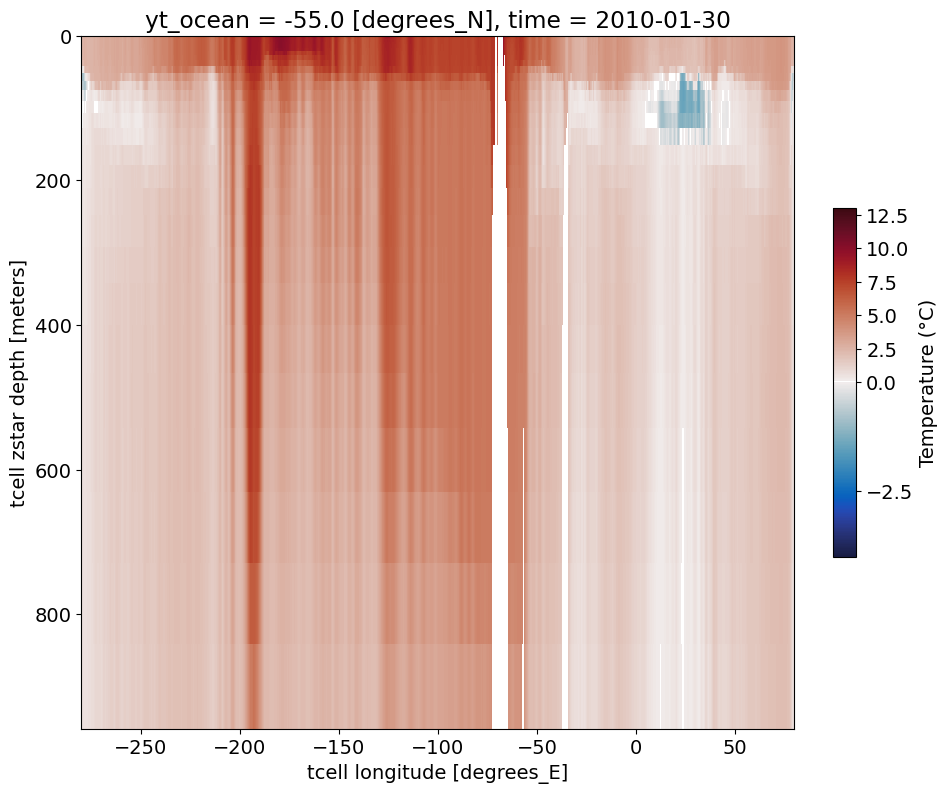

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import cmocean.cm as cm

plt.figure(figsize=(10, 9))
ax = plt.axes()

# Custom colormap 
cmap = cm.balance
colors = cmap(np.linspace(0, 1, 256))
colors[128] = [1, 1, 1, 1]
new_cmap = mcolors.LinearSegmentedColormap.from_list('balance_white_center', colors)
norm = mcolors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=13)

temp_depth.sel(time ='2010-01-15T12:00:00', method = 'nearest').sel(yt_ocean = -55, method = 'nearest').sel(st_ocean = slice(0,1000)).plot(
    vmin=-4,
    vmax=13,
    ax = ax,
    cmap = new_cmap,
    norm=norm,
    cbar_kwargs={"label": "Temperature (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

ax.set_ylim(ax.get_ylim()[::-1])

## Creating the database of sea surface temperature

In [3]:
import cosima_cookbook as cc

db = 'local_scratch_0p25_model.db'
session = cc.database.create_session(db)

directory_list=['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1']

In [4]:
# ##Maurice provided code to access the Ryan Holmes run as this is not an official run
# directory_list=['/g/data/e14/rmh561/access-om2/archive/025deg_era5_iaf_1958cycle1']
# cc.database.build_index(directory_list, session)

sss = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='sss',
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})



In [ ]:
## Converting to K
sst = temp - 273.15
sst


In [5]:
## Only selecting the Southern Ocean portion to reduce the size of the data that must be dealt with
southern_ocean_coverage = sss.sel(yt_ocean = slice(-90,-55))
# geolon_t = southern_ocean_coverage.yt_ocean
# geolat_t = southern_ocean_coverage.xt_ocean

# southern_ocean_coverage = southern_ocean_coverage.assign_coords({"geolat_t": southern_ocean_coverage["yt_ocean"], "geolon_t": southern_ocean_coverage["xt_ocean"]})
# southern_ocean_coverage

## Plotting SST in the Southern Ocean

In [6]:
## Plotting the SST data in a Southern Ocean Polar Coordinate system 
%matplotlib inline
projection = ccrs.SouthPolarStereo()
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Custom colormap 
cmap = cm.cm.balance
colors = cmap(np.linspace(0, 1, 256))
colors[128] = [1, 1, 1, 1]
# new_cmap = mcolors.LinearSegmentedColormap.from_list('balance_white_center', colors)
# norm = mcolors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=14)

southern_ocean_coverage.sel(time = '2010-01-20T12:00:00.000000000').plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=50,
    extend="both",
    cmap=cmap,
    # norm = norm,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax = ax
)

plt.show()

NameError: name 'ccrs' is not defined

In [16]:
cd "/g/data/e14/ts7341/SST_0p25_2010_Event/"

[Errno 2] No such file or directory: '/g/data/e14/ts7341/SST_0p25_2010_Event/'
/home/156/ts7341/g/data/e14/ts7341


In [30]:
## Movie for SST
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
import cmocean.cm as cm
# import xarray as xr
# from xmovie import Movie

# southern_ocean_coverage = sst.sel(yt_ocean = slice(-90,-55))

# geolon_t = southern_ocean_coverage.yt_ocean
# geolat_t = southern_ocean_coverage.xt_ocean

# southern_ocean_coverage = southern_ocean_coverage.assign_coords({"geolat_t": southern_ocean_coverage["yt_ocean"], "geolon_t": southern_ocean_coverage["xt_ocean"]})
# southern_ocean_coverage = southern_ocean_coverage.sel(time = slice('2009-11-30T12:00:00.000000000', '2010-03-01T12:00:00.000000000')) #'2018-01-01T12:00:00'))

# def plot_southern_ocean_sst(da, fig, frame, *args):
#     """
    # Function to plot Southern Ocean SST for a given time frame.

    # Parameters:
    #     da (xarray.DataArray): The dataset containing SST values.
    #     fig (matplotlib.figure.Figure): The figure to update.
    #     frame (int): The time index passed by xmovie.
    # Returns:
    #     ax (matplotlib.axes._subplots.AxesSubplot): The updated axis.
    #     pp (matplotlib.collections.QuadMesh): The plotted data.
    # """

    # projection = ccrs.SouthPolarStereo()
    # ax = fig.add_subplot(1, 1, 1, projection=projection)

#     land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
#     ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#     ax.coastlines(resolution="50m")

#     ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())

#     theta = np.linspace(0, 2 * np.pi, 100)
#     center, radius = [0.5, 0.5], 0.5
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)
#     ax.set_boundary(circle, transform=ax.transAxes)

#     pp = da.isel(time=frame).plot(
#         ax=ax,
#         x="xt_ocean",
#         y="yt_ocean",
#         transform=ccrs.PlateCarree(),
#         vmin=-4,
#         vmax=10,
#         extend="both",
#         cmap=cm.balance,
#         cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7}
#     )

#     return ax, pp  
    
# southern_ocean_coverage
    
# mov = Movie(southern_ocean_coverage, plot_southern_ocean_sst, input_check=False)
# mov.save("southern_ocean_sst_2010_event_0p25.mp4")

In [7]:
import xarray as xr
import numpy as np

def calculate_sst_anomaly_with_smoothing(data, window=15):
    """
    Calculate daily SST anomalies from a 30-year climatology,
    with smoothed climatology using a centered rolling mean.

    Args:
        data (xarray.DataArray): SST data with 'time', 'lat', 'lon'.
        window (int): Rolling window size in days (default 15).

    Returns:
        tuple of xarray.DataArray:
            - smoothed_climatology (by dayofyear)
            - anomalies (original SST - smoothed climatology)
    """
    
    # Step 1: Select baseline period for climatology
    baseline = data.sel(time=slice("1982-01-01", "2011-12-31"))

    # Step 2: Group by dayofyear and average over time
    clim = baseline.groupby("time.dayofyear").mean("time")

    # Step 3: Pad climatology to allow centered rolling smoothing
    pad_width = window // 2
    pre = clim.sel(dayofyear=slice(366 - pad_width, 365))
    post = clim.sel(dayofyear=slice(1, pad_width))
    clim_padded = xr.concat([pre, clim, post], dim="dayofyear")

    # Step 4: Smooth
    clim_smoothed = clim_padded.rolling(dayofyear=window, center=True).mean()

    # Step 5: Drop padding and reset correct dayofyear coordinates
    valid = clim_smoothed.isel(dayofyear=slice(pad_width, pad_width + 365))
    valid = valid.assign_coords(dayofyear=np.arange(1, 366))  # reset to 1..365

    # Step 6: Subtract smoothed climatology using groupby
    anomalies = data.groupby("time.dayofyear") - valid

    return valid, anomalies


In [8]:
valid, anomalies = calculate_sst_anomaly_with_smoothing(southern_ocean_coverage)

  result = blockwise(



In [9]:
anomalies

<xarray.DataArray 'sss' (time: 24106, yt_ocean: 233, xt_ocean: 1440)> Size: 32GB
dask.array<sub, shape=(24106, 233, 1440), dtype=float32, chunksize=(1, 34, 206), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
  * time       (time) datetime64[ns] 193kB 1957-12-30T12:00:00 ... 2023-12-29...
    dayofyear  (time) int64 193kB 364 365 1 2 3 4 5 ... 358 359 360 361 362 363

In [10]:
## Plotting the SSTA data in the Southern Ocean projection
%matplotlib inline
projection = ccrs.SouthPolarStereo()
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

sssas = anomalies.sel(yt_ocean = slice(-90,-55))

sssas.sel(time = '2022-01-30T12:00:00.000000000').plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="both",
    cmap=cm.cm.balance,
    cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax = ax
)

plt.show()

NameError: name 'ccrs' is not defined

In [13]:

anom = anomalies.sel(time = slice('2021-08-01','2022-04-01')).\
                 sel(xt_ocean = -175, yt_ocean = -74, method ='nearest')
                 #mean(['xt_ocean','yt_ocean'])
plt.plot(anom['time'], anom.values)
plt.show()

In [19]:
cd "/g/data/e14/ts7341/SSTA_0p25_2010_Event/"

[Errno 2] No such file or directory: '/g/data/e14/ts7341/SSTA_0p25_2010_Event/'
/home/156/ts7341/g/data/e14/ts7341


In [17]:
# ## SSTA movie
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cft
# import matplotlib.path as mpath
# import cmocean.cm as cm
# import xarray as xr
# from xmovie import Movie

# sstas = sstas.sel(yt_ocean = slice(-90,-55))
# sstas = sstas.sel(time = slice('2009-11-30T12:00:00.000000000', '2010-03-01T12:00:00.000000000')) #'2018-01-01T12:00:00'))

# def plot_southern_ocean_ssta(da, fig, frame, *args):
#     """
#     Function to plot Southern Ocean SST for a given time frame.

#     Parameters:
#         da (xarray.DataArray): The dataset containing SSTA values.
#         fig (matplotlib.figure.Figure): The figure to update.
#         frame (int): The time index passed by xmovie.
#     Returns:
#         ax (matplotlib.axes._subplots.AxesSubplot): The updated axis.
#         pp (matplotlib.collections.QuadMesh): The plotted data.
#     """

#     projection = ccrs.SouthPolarStereo()
#     ax = fig.add_subplot(1, 1, 1, projection=projection)

#     land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
#     ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#     ax.coastlines(resolution="50m")

#     ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())

#     theta = np.linspace(0, 2 * np.pi, 100)
#     center, radius = [0.5, 0.5], 0.5
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)
#     ax.set_boundary(circle, transform=ax.transAxes)

#     pp = da.isel(time=frame).plot(
#         ax=ax,
#         x="xt_ocean",
#         y="yt_ocean",
#         transform=ccrs.PlateCarree(),
#         vmin=-2,
#         vmax=5,
#         extend="both",
#         cmap=cm.balance,
#         cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7}
#     )

#     return ax, pp  
    
# mov = Movie(sstas, plot_southern_ocean_ssta, input_check=False)
# mov.save("southern_ocean_ssta_2010_event_0p25.mp4")

In [18]:
# import matplotlib.pyplot as plt

# # Select fixed latitude and time range
# ds_hov = sstas.sel(yt_ocean=-60, method='nearest')
# ds_hov = ds_hov.sel(time=slice("2007-10-01", "2012-12-01"))
# ds_hov = ds_hov.sel(xt_ocean = slice(-280,-250))
# ds_hov

# # Extract values
# time = ds_hov["time"].values
# lon = ds_hov["xt_ocean"].values

# # Plot with imshow for faster performance
# plt.figure(figsize=(12, 6))
# plt.imshow(ds_hov.values.T, aspect='auto', cmap="bwr",
#            extent=[ds_hov['xt_ocean'].min(), ds_hov['xt_ocean'].max(),
#                    ds_hov['time'].max(), ds_hov['time'].min()])

# plt.colorbar(label="Temperature (°C)")
# plt.xlabel("Longitude")
# plt.ylabel("Time")
# plt.title("Hovmöller Diagram at Latitude -60")
# plt.show()



## Plotting Sea Ice Contours + SSTas 

### Load in SSTa

In [4]:
pattern = '/g/data/e14/ts7341/thresholds_antarctic/Climatology/*nc'

import xarray as xr 

def select_sst_only(ds):
    return ds[["sst"]]

Seas = xr.open_mfdataset(
          pattern,
          combine="by_coords",        
          parallel=True,
          preprocess=select_sst_only
)

In [5]:
print(Seas)

<xarray.Dataset> Size: 561MB
Dimensions:    (lat: 266, lon: 1440, dayofyear: 366)
Coordinates:
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    st_ocean   int64 8B 0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    sst        (lat, lon, dayofyear) float32 561MB dask.array<chunksize=(266, 240, 366), meta=np.ndarray>


In [6]:
import xarray as xr

pattern = "/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1/output*/ocean/ocean_daily.nc"

def select_sst_only(ds):
    return ds[["sst"]]

ds = xr.open_mfdataset(
    # chunks = {"time": -1, "xt_ocean": 450, "yt_ocean": 720},
    pattern,
    combine="by_coords",        
    parallel=True,              
    preprocess=select_sst_only)

ds.coords["st_ocean"] = 0

In [7]:
ds = ds.sel(yt_ocean = slice(-82,-50)).sel(xt_ocean = slice(-280,80))
ds = ds.sel(time=slice('1980-01-01', '2022-12-31'))
print(ds)

<xarray.Dataset> Size: 24GB
Dimensions:   (time: 15706, yt_ocean: 266, xt_ocean: 1440)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
  * time      (time) datetime64[ns] 126kB 1980-01-01T12:00:00 ... 2022-12-31T...
    st_ocean  int64 8B 0
Data variables:
    sst       (time, yt_ocean, xt_ocean) float32 24GB dask.array<chunksize=(1, 216, 240), meta=np.ndarray>
Attributes:
    filename:   ocean_daily.nc
    title:      ACCESS-OM2
    grid_type:  mosaic
    grid_tile:  1
    history:    20240726T0821Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...


In [8]:
# # Rename dimensions
ds = ds.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

# # Convert surface_temp from Kelvin to Celsius
ds_input = ds - 273.15
ds_input.attrs['units'] = 'deg C'  # Update units attribute

# # Display the modified dataset structure
ds_input = ds_input.sst

In [9]:
ds_input = ds_input.assign_coords(dayofyear=ds_input['time'].dt.dayofyear)
print(ds_input)

<xarray.DataArray 'sst' (time: 15706, lat: 266, lon: 1440)> Size: 24GB
dask.array<sub, shape=(15706, 266, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * time       (time) datetime64[ns] 126kB 1980-01-01T12:00:00 ... 2022-12-31...
    st_ocean   int64 8B 0
    dayofyear  (time) int64 126kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365


In [10]:
import xarray as xr

Seas_aligned = Seas.interp(
    dayofyear=xr.DataArray(ds_input['dayofyear'].values, dims="time")
)


In [11]:
Seas_aligned = Seas_aligned.sst

In [12]:
SSTa = ds_input - Seas_aligned
print(SSTa) ## SSTA loaded

<xarray.DataArray 'sst' (time: 15706, lat: 266, lon: 1440)> Size: 24GB
dask.array<sub, shape=(15706, 266, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * time       (time) datetime64[ns] 126kB 1980-01-01T12:00:00 ... 2022-12-31...
    st_ocean   int64 8B 0
    dayofyear  (time) int64 126kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365


In [13]:
SSTa = SSTa.chunk({'time':-1,'lon':'300MB','lat':'300MB'})

In [14]:
anom = SSTa.sel(lat = slice(-90,-50))

In [15]:
anom = anom.drop_vars(['dayofyear', 'st_ocean'])

In [16]:
anom

<xarray.DataArray 'sst' (time: 15706, lat: 266, lon: 1440)> Size: 24GB
dask.array<rechunk-p2p, shape=(15706, 266, 1440), dtype=float32, chunksize=(15706, 51, 92), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * lat      (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * time     (time) datetime64[ns] 126kB 1980-01-01T12:00:00 ... 2022-12-31T1...

### Sea Ice Loaded In

In [17]:
## Sea Ice
import cosima_cookbook as cc

db = 'local_scratch_0p25_model.db'
session = cc.database.create_session(db)

directory_list=['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1']

In [18]:
aice = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='aice', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'nj': '300MB', 'ni': '300MB'})

In [19]:
aice

<xarray.DataArray 'aice' (time: 24106, nj: 1080, ni: 1440)> Size: 150GB
dask.array<concatenate, shape=(24106, 1080, 1440), dtype=float32, chunksize=(31, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 193kB 1958-01-02 1958-01-03 ... 2024-01-01
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_195...
    contact:        Ryan Holmes
    email:          ryan.holmes@bom.gov.au
    created:        2023-07-14
    description:    0.25 degree ACCESS-OM2 global model configuration with ER...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...
    url:            https://github.com/rmholmes/025deg_era5_iaf/tree/1958star...

In [20]:
aice = aice.drop_vars(['ULAT', 'ULON'])

In [21]:
## Load in the area for the model - used to convert sea ice to this xt_ocean/yt_ocean coords
area = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='area_t', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1)
area

<xarray.DataArray 'area_t' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
dask.array<open_dataset-area_t, shape=(1080, 1440), dtype=float32, chunksize=(216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(216, 240), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(216, 240), meta=np.ndarray>
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958...
    contact:       Ryan Holmes
    email:         ryan.holmes@bom.gov.au
    created:       2023-07-14
    description:   0.25 degree ACCESS-OM2 global model configuration with ERA...
    notes:         Source code: https://github.com/COSIMA/access-om2\nLicense...
    url:           https://github.com/rmholmes/025deg_era5_iaf/tree/1958start...

In [22]:
import xarray as xr
import cf_xarray as cfxr

# Assigning the coordinates from 'area' to 'aice'
aice.coords['ni'] = area['xt_ocean'].values  # Longitude coordinate
aice.coords['nj'] = area['yt_ocean'].values  # Latitude coordinate

# Copying attributes from 'area' to 'aice'
aice.ni.attrs = area.xt_ocean.attrs
aice.nj.attrs = area.yt_ocean.attrs

# Renaming the dimensions 
aice = aice.rename({'ni': 'xt_ocean', 'nj': 'yt_ocean'})

In [23]:
aice.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates:   longitude: ['TLON', 'xt_ocean']
                        latitude: ['TLAT', 'yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

In [24]:
SH_sea_ice = aice.cf.sel(yt_ocean=slice(-90, -50)).sel(time = slice('1982','2024'))
SH_sea_ice 

<xarray.DataArray 'aice' (time: 15341, yt_ocean: 266, xt_ocean: 1440)> Size: 24GB
dask.array<getitem, shape=(15341, 266, 1440), dtype=float32, chunksize=(31, 266, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2024-01-01
    TLON      (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_195...
    contact:        Ryan Holmes
    email:          ryan.holmes@bom.gov.au
    created:        2023-07-14
    description:    0.25 degree ACCESS-OM2 global model configuration with ER...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...
    url:            https://github.com/rmholmes/025deg_era5_iaf/tree/1958star...

In [25]:
ice = SH_sea_ice.sel(time = slice('1982','2023-12-31'))
ice_with_doy = ice.assign_coords(dayofyear=SH_sea_ice['time'].dt.dayofyear)

In [26]:
ice_with_doy

<xarray.DataArray 'aice' (time: 15340, yt_ocean: 266, xt_ocean: 1440)> Size: 24GB
dask.array<getitem, shape=(15340, 266, 1440), dtype=float32, chunksize=(31, 266, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
    TLON       (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
    TLAT       (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_195...
    contact:        Ryan Holmes
    email:          ryan.holmes@bom.gov.au
    created:        2023-07-14
    description:    0.25 degree ACCESS-OM2 global model configuration with ER...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...
    url:            https://github.com/rmholmes/025deg_era5_iaf/tree/1958star...

In [27]:
def sea_ice_climatology(data, start_year=1982, end_year=2011):
    """
    Returns the daily climatological average with a 15-day centered rolling mean.

    Parameters:
    - data: xarray DataArray containing sea ice concentration with a 'time' dimension
    - start_year: int, start year for climatology (default 1982)
    - end_year: int, end year for climatology (default 2011)

    Returns:
    - xarray DataArray: smoothed 365-day (or 366 if leap days included) climatology
    """
    import xarray as xr

    # Filter data within the desired year range
    data_in_range = data.sel(
        time=(data['time'].dt.year >= start_year) & 
             (data['time'].dt.year <= end_year)
    )

    daily_climatology = data_in_range.groupby('time.dayofyear').mean('time')

    smoothed_climatology = daily_climatology.rolling(dayofyear=15, center=True).mean()

    return smoothed_climatology

smoothed_climatology = sea_ice_climatology(ice_with_doy)

In [28]:
smoothed_climatology

<xarray.DataArray 'aice' (dayofyear: 366, yt_ocean: 266, xt_ocean: 1440)> Size: 561MB
dask.array<truediv, shape=(366, 266, 1440), dtype=float32, chunksize=(18, 38, 206), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
    TLON       (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
    TLAT       (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_195...
    contact:        Ryan Holmes
    email:          ryan.holmes@bom.gov.au
    created:        2023-07-14
    description:    0.25 degree ACCESS-OM2 global model configuration with ER...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...
    url:            https://github.com/rmholmes/025deg_era5_iaf/tree/1958star...

In [29]:
ice_clim_aligned = smoothed_climatology.sel(dayofyear=ice_with_doy['dayofyear'])

In [30]:
ice_clim_aligned

<xarray.DataArray 'aice' (time: 15340, yt_ocean: 266, xt_ocean: 1440)> Size: 24GB
dask.array<getitem, shape=(15340, 266, 1440), dtype=float32, chunksize=(17, 38, 206), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
    TLON       (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
    TLAT       (yt_ocean, xt_ocean) float32 2MB dask.array<chunksize=(266, 1440), meta=np.ndarray>
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
  * time       (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_195...
    contact:        Ryan Holmes
    email:          ryan.holmes@bom.gov.au
    created:        2023-07-14
    description:    0.25 degree ACCESS-OM2 global model configuration with ER...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...
    url:            https://github.com/rmholmes/025deg_era5_iaf/tree/1958star...

In [35]:
# clim = smoothed_climatology.sel(xt_ocean = slice(-280,-270), yt_ocean = slice(-65,-61)).mean('yt_ocean').mean('xt_ocean')
# plt.plot(clim['dayofyear'], clim)
# plt.show()

KeyboardInterrupt: 

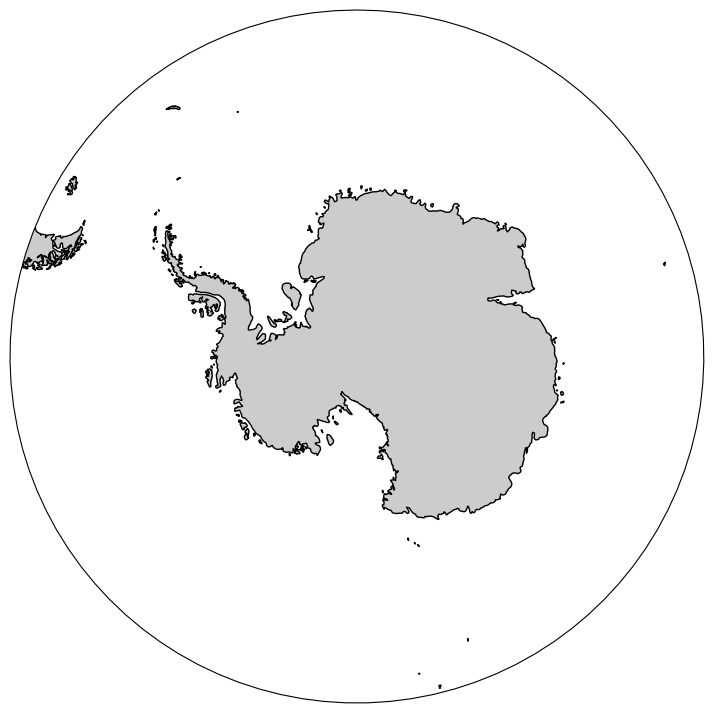

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cm
import matplotlib.path as mpath
%matplotlib inline

levels = [0.2]

# Set projection and figure
projection = ccrs.SouthPolarStereo()
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={'projection': projection})

# Set extent and add features
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Add circular boundary for the polar projection
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# anom_sample = anom.sel(time = "2022-01-31", method = 'nearest')
# anom_sample.plot(
#     x="lon",
#     y="lat",
#     transform=ccrs.PlateCarree(),
#     vmin=-3,
#     vmax=3,
#     cmap=cm.balance,
#     extend="both",
#     cbar_kwargs={
#         "label": "SSTA (°C)",
#         "fraction": 0.03,
#         "aspect": 15,
#         "shrink": 0.7
#     },
#     ax=ax
# )

ice_climate = ice_clim_aligned.sel(time = '2022-01-01')
contour_clim = ice_climate.plot.contour(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=levels,
    colors=['black'], 
    linewidths=2,
    add_colorbar=False
)

sea_ice_2023 = SH_sea_ice.sel(time = '2022-01-01')
contour_day = sea_ice_2023.plot.contour(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=levels,
    colors=['orange'],
    linewidths=2,
    add_colorbar=False
)

plt.show()



In [ ]:
# def plot_southern_ocean_sst(da, fig, frame, *args):
#     """
    # Function to plot Southern Ocean SST for a given time frame.

    # Parameters:
    #     da (xarray.DataArray): The dataset containing SST values.
    #     fig (matplotlib.figure.Figure): The figure to update.
    #     frame (int): The time index passed by xmovie.
    # Returns:
    #     ax (matplotlib.axes._subplots.AxesSubplot): The updated axis.
    #     pp (matplotlib.collections.QuadMesh): The plotted data.
    # """

    # projection = ccrs.SouthPolarStereo()
    # ax = fig.add_subplot(1, 1, 1, projection=projection)

#     land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
#     ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#     ax.coastlines(resolution="50m")

#     ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())

#     theta = np.linspace(0, 2 * np.pi, 100)
#     center, radius = [0.5, 0.5], 0.5
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)
#     ax.set_boundary(circle, transform=ax.transAxes)

#     pp = da.isel(time=frame).plot(
#         ax=ax,
#         x="xt_ocean",
#         y="yt_ocean",
#         transform=ccrs.PlateCarree(),
#         vmin=-4,
#         vmax=10,
#         extend="both",
#         cmap=cm.balance,
#         cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7}
#     )

#     return ax, pp  
    
# southern_ocean_coverage
    
# mov = Movie(southern_ocean_coverage, plot_southern_ocean_sst, input_check=False)
# mov.save("southern_ocean_sst_2010_event_0p25.mp4")